In [43]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# %matplotlib widget
import seaborn as sns
import plotly.express as px

# import folium
# from folium.plugins import HeatMap
# 
# from wordcloud import WordCloud
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from scipy.stats import probplot
import pylab

import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

import category_encoders as ce
from datetime import datetime

# 0. Import Data

## 0.1 Datasets Path

In [44]:
train_data_path = './dataset/train.csv'

test_data_path = './dataset/test.csv'

mrt_exist_data_path = './dataset/auxiliary-data/sg-mrt-existing-stations.csv'
mrt_planned_data_path = './dataset/auxiliary-data/sg-mrt-planned-stations.csv'
mall_data_path = './dataset/auxiliary-data/sg-shopping-malls.csv'
primary_school_data_path = './dataset/auxiliary-data/sg-primary-schools.csv'

coe_price_data_path = './dataset/auxiliary-data/sg-coe-prices.csv'
stock_price_data_path = './dataset/auxiliary-data/sg-stock-prices.csv'

## 0.2 Load Data

In [45]:
train_data = pd.read_csv(train_data_path)

test_data = pd.read_csv(test_data_path)
test_data['monthly_rent'] = 0

mrt_exist_data = pd.read_csv(mrt_exist_data_path)
mrt_planned_data = pd.read_csv(mrt_planned_data_path)
mall_data = pd.read_csv(mall_data_path)
primary_school_data = pd.read_csv(primary_school_data_path)

coe_price_data = pd.read_csv(coe_price_data_path)
stock_price_data = pd.read_csv(stock_price_data_path)

# 1. Cleaning

In [46]:
train_data['flat_type'] = train_data['flat_type'].str.replace("-", " ")

test_data['flat_type'] = test_data['flat_type'].str.replace("-", " ")

train_data.head()
# test_data.head()

rent_approval_date             town block            street_name  flat_type  \
0            2021-09      jurong east   257  Jurong East Street 24     3 room   
1            2022-05            bedok   119       bedok north road     4 room   
2            2022-10        toa payoh   157     lorong 1 toa payoh     3 room   
3            2021-08        pasir ris   250    Pasir Ris Street 21  executive   
4            2022-11  kallang/whampoa    34           Whampoa West     3 room   

       flat_model  floor_area_sqm furnished  lease_commence_date  latitude  \
0  new generation            67.0       yes                 1983  1.344518   
1  new generation            92.0       yes                 1978  1.330186   
2        improved            67.0       yes                 1971  1.332242   
3       apartment           149.0       yes                 1993  1.370239   
4        improved            68.0       yes                 1972  1.320502   

    longitude  elevation            subzone planning_area          region  \
0  103.738630        0.0         yuhua east   jurong east     west region   
1  103.938717        0.0        bedok north         bedok     east region   
2  103.845643        0.0  toa payoh central     toa payoh  central region   
3  103.962894        0.0    pasir ris drive     pasir ris     east region   
4  103.863341        0.0          bendemeer       kallang  central region   

   monthly_rent  
0          1600  
1          2250  
2          1900  
3          2850  
4          2100

# 2. Encoding

## 2.0 Encoding Functions
The encoding functions we have now are: one-hot encoding, binary encoding, word embedding(TODO), normalization, dict mapping, function mapping, drop attribute.

In [47]:
def encode_one_hot(data: pd.DataFrame, column_name: str, encoder: ce.OneHotEncoder):
    return encoder.transform(data)

def encode_binary(data: pd.DataFrame, column_name: str, encoder: ce.BinaryEncoder):
    return encoder.transform(data)

def encode_word_embedding(data: pd.DataFrame, column_name: str):
    # TODO
    pass

def encode_normalization(data: pd.DataFrame, column_name: str, min_value, max_value, keep_origin=False):
    new_column_name = column_name
    if keep_origin:
        new_column_name = column_name + '_norm'
    data[new_column_name] = (data[column_name] - min_value) / (max_value - min_value)
    return data

def encode_dict_map(data: pd.DataFrame, column_name: str, transform_map: dict):
    data[column_name] = data[column_name].map(transform_map)
    return data

def encode_function_map(data: pd.DataFrame, column_name: str, transform_func):
    data[column_name] = data[column_name].apply(transform_func)
    return data

def encode_drop(data: pd.DataFrame, column_name: str):
    data.drop(columns=[column_name], inplace=True)
    return data

## 2.1 Attribute: rent_approval_date
There are two ways to encode this attribute. First is function mapping, according to the function "year*10+month". Second is drop the attribute, since this attribute may be replaced by "lease commence date" or the stock amount. For now, I use the first way.

TODO: Consider the second way and see if there will be any improvement or not.

In [48]:
def transform_func_date(value):
    splits = value.split('-')
    return int(splits[0]) * 100 + int(splits[1])

train_data = encode_function_map(train_data, 'rent_approval_date', transform_func_date)

test_data = encode_function_map(test_data, 'rent_approval_date', transform_func_date)

train_data.head()
# test_data.head()

rent_approval_date             town block            street_name  \
0              202109      jurong east   257  Jurong East Street 24   
1              202205            bedok   119       bedok north road   
2              202210        toa payoh   157     lorong 1 toa payoh   
3              202108        pasir ris   250    Pasir Ris Street 21   
4              202211  kallang/whampoa    34           Whampoa West   

   flat_type      flat_model  floor_area_sqm furnished  lease_commence_date  \
0     3 room  new generation            67.0       yes                 1983   
1     4 room  new generation            92.0       yes                 1978   
2     3 room        improved            67.0       yes                 1971   
3  executive       apartment           149.0       yes                 1993   
4     3 room        improved            68.0       yes                 1972   

   latitude   longitude  elevation            subzone planning_area  \
0  1.344518  103.738630        0.0         yuhua east   jurong east   
1  1.330186  103.938717        0.0        bedok north         bedok   
2  1.332242  103.845643        0.0  toa payoh central     toa payoh   
3  1.370239  103.962894        0.0    pasir ris drive     pasir ris   
4  1.320502  103.863341        0.0          bendemeer       kallang   

           region  monthly_rent  
0     west region          1600  
1     east region          2250  
2  central region          1900  
3     east region          2850  
4  central region          2100

## 2.2 Attribute: town
There are four ways to encode this attribute. First is one-hot encoding. But there are 26 categories in this atribute. Second is binary encoding. Third is word embedding. Forth is drop this attribute, since this attribute may be replaced by "subzone-planning area-region" or "latitude-longitude". For now, I choose the second way.

TODO: Consider the forth way.

In [49]:
# town_encoder = ce.OneHotEncoder(cols=['town']).fit(train_data)
town_encoder = ce.BinaryEncoder(cols=['town']).fit(train_data)

# train_data = encode_one_hot(train_data, 'town', town_encoder)
train_data = encode_binary(train_data, 'town', town_encoder)
# train_data = encode_word_embedding(train_data, 'town')
# train_data = encode_drop(train_data, 'town')

# test_data = encode_one_hot(test_data, 'town', town_encoder)
test_data = encode_binary(test_data, 'town', town_encoder)
# test_data = encode_word_embedding(test_data, 'town')
# test_data = encode_drop(test_data, 'town')

train_data.head()
# test_data.head()

rent_approval_date  town_0  town_1  town_2  town_3  town_4 block  \
0              202109       0       0       0       0       1   257   
1              202205       0       0       0       1       0   119   
2              202210       0       0       0       1       1   157   
3              202108       0       0       1       0       0   250   
4              202211       0       0       1       0       1    34   

             street_name  flat_type      flat_model  floor_area_sqm furnished  \
0  Jurong East Street 24     3 room  new generation            67.0       yes   
1       bedok north road     4 room  new generation            92.0       yes   
2     lorong 1 toa payoh     3 room        improved            67.0       yes   
3    Pasir Ris Street 21  executive       apartment           149.0       yes   
4           Whampoa West     3 room        improved            68.0       yes   

   lease_commence_date  latitude   longitude  elevation            subzone  \
0                 1983  1.344518  103.738630        0.0         yuhua east   
1                 1978  1.330186  103.938717        0.0        bedok north   
2                 1971  1.332242  103.845643        0.0  toa payoh central   
3                 1993  1.370239  103.962894        0.0    pasir ris drive   
4                 1972  1.320502  103.863341        0.0          bendemeer   

  planning_area          region  monthly_rent  
0   jurong east     west region          1600  
1         bedok     east region          2250  
2     toa payoh  central region          1900  
3     pasir ris     east region          2850  
4       kallang  central region          2100

## 2.3 Attribute: block
There are two ways to encode. Since there are a lot of catigories in this attribute, I don't think it is a good idea to use one-hot encoding. And, since the value is not words, I don't think it have any semantic info and can be encoded by word embedding. So, first way is binary encoding. Second way is drop attribute, similar to attribute "town". For now, I choose the first way.

TODO: Consider the second way.

In [50]:
block_encoder = ce.BinaryEncoder(cols=['block']).fit(train_data)

train_data = encode_binary(train_data, 'block', block_encoder)
# train_data = encode_drop(train_data, 'block')

test_data = encode_binary(test_data, 'block', block_encoder)
# test_data = encode_drop(test_data, 'block')

train_data.head()
# test_data.head()

rent_approval_date  town_0  town_1  town_2  town_3  town_4  block_0  \
0              202109       0       0       0       0       1        0   
1              202205       0       0       0       1       0        0   
2              202210       0       0       0       1       1        0   
3              202108       0       0       1       0       0        0   
4              202211       0       0       1       0       1        0   

   block_1  block_2  block_3  ...  floor_area_sqm  furnished  \
0        0        0        0  ...            67.0        yes   
1        0        0        0  ...            92.0        yes   
2        0        0        0  ...            67.0        yes   
3        0        0        0  ...           149.0        yes   
4        0        0        0  ...            68.0        yes   

   lease_commence_date  latitude   longitude  elevation            subzone  \
0                 1983  1.344518  103.738630        0.0         yuhua east   
1                 1978  1.330186  103.938717        0.0        bedok north   
2                 1971  1.332242  103.845643        0.0  toa payoh central   
3                 1993  1.370239  103.962894        0.0    pasir ris drive   
4                 1972  1.320502  103.863341        0.0          bendemeer   

   planning_area          region monthly_rent  
0    jurong east     west region         1600  
1          bedok     east region         2250  
2      toa payoh  central region         1900  
3      pasir ris     east region         2850  
4        kallang  central region         2100  

[5 rows x 31 columns]

## 2.4 Attribute: street name
There are three ways to encode. Similar to attribute "block", this attribute is not suitable for one-hot encoding. So, first way is binary encoding. Second way is word embedding, since the value in this attribute have semantic info. Third way is drop attribute, similar to attribute "town". For now, I choose the first way.

TODO: Consider the third way.

In [51]:
street_name_encoder = ce.BinaryEncoder(cols=['street_name']).fit(train_data)

train_data = encode_binary(train_data, 'street_name', street_name_encoder)
# train_data = encode_word_embedding(train_data, 'street_name')
# train_data = encode_drop(train_data, 'street_name')

test_data = encode_binary(test_data, 'street_name', street_name_encoder)
# test_data = encode_word_embedding(test_data, 'street_name')
# test_data = encode_drop(test_data, 'street_name')
    
train_data.head()
# test_data.head()

rent_approval_date  town_0  town_1  town_2  town_3  town_4  block_0  \
0              202109       0       0       0       0       1        0   
1              202205       0       0       0       1       0        0   
2              202210       0       0       0       1       1        0   
3              202108       0       0       1       0       0        0   
4              202211       0       0       1       0       1        0   

   block_1  block_2  block_3  ...  floor_area_sqm  furnished  \
0        0        0        0  ...            67.0        yes   
1        0        0        0  ...            92.0        yes   
2        0        0        0  ...            67.0        yes   
3        0        0        0  ...           149.0        yes   
4        0        0        0  ...            68.0        yes   

   lease_commence_date  latitude   longitude  elevation            subzone  \
0                 1983  1.344518  103.738630        0.0         yuhua east   
1                 1978  1.330186  103.938717        0.0        bedok north   
2                 1971  1.332242  103.845643        0.0  toa payoh central   
3                 1993  1.370239  103.962894        0.0    pasir ris drive   
4                 1972  1.320502  103.863341        0.0          bendemeer   

   planning_area          region  monthly_rent  
0    jurong east     west region          1600  
1          bedok     east region          2250  
2      toa payoh  central region          1900  
3      pasir ris     east region          2850  
4        kallang  central region          2100  

[5 rows x 41 columns]

## 2.5 Attribute: flat type
There are three ways to encode. First is one-hot encoding since only 5 catagories in this attribute. Second is binary encoding. Third is dict mapping to map the type into number in order. For now, I choose the third way.

TODO: Change the map value

In [52]:
# flat_type_encoder = ce.OneHotEncoder(cols=['flat_type']).fit(train_data)
# flat_type_encoder = ce.BinaryEncoder(cols=['flat_type']).fit(train_data)
flat_type_mapping_dict = {'2 room': 2, '3 room': 3, '4 room': 4, '5 room': 5, 'executive': 6}

# train_data = encode_one_hot(train_data, 'flat_type', flat_type_encoder)
# train_data = encode_binary(train_data, 'flat_type', flat_type_encoder)
train_data = encode_dict_map(train_data, 'flat_type', flat_type_mapping_dict)

# test_data = encode_one_hot(test_data, 'flat_type', flat_type_encoder)
# test_data = encode_binary(test_data, 'flat_type', flat_type_encoder)
test_data = encode_dict_map(test_data, 'flat_type', flat_type_mapping_dict)

train_data.head()
# test_data.head()

rent_approval_date  town_0  town_1  town_2  town_3  town_4  block_0  \
0              202109       0       0       0       0       1        0   
1              202205       0       0       0       1       0        0   
2              202210       0       0       0       1       1        0   
3              202108       0       0       1       0       0        0   
4              202211       0       0       1       0       1        0   

   block_1  block_2  block_3  ...  floor_area_sqm  furnished  \
0        0        0        0  ...            67.0        yes   
1        0        0        0  ...            92.0        yes   
2        0        0        0  ...            67.0        yes   
3        0        0        0  ...           149.0        yes   
4        0        0        0  ...            68.0        yes   

   lease_commence_date  latitude   longitude  elevation            subzone  \
0                 1983  1.344518  103.738630        0.0         yuhua east   
1                 1978  1.330186  103.938717        0.0        bedok north   
2                 1971  1.332242  103.845643        0.0  toa payoh central   
3                 1993  1.370239  103.962894        0.0    pasir ris drive   
4                 1972  1.320502  103.863341        0.0          bendemeer   

   planning_area          region  monthly_rent  
0    jurong east     west region          1600  
1          bedok     east region          2250  
2      toa payoh  central region          1900  
3      pasir ris     east region          2850  
4        kallang  central region          2100  

[5 rows x 41 columns]

## 2.6 Attribute: flat model
There are four ways to encode. First is one-hot encoding. But there are XX catagories in this attribute. Second is bianry encoding. Third is word embedding. Forth is drop attribute. For now, I choose the second way.

In [53]:
# flat_model_encoder = ce.OneHotEncoder(cols=['flat_model']).fit(train_data)
flat_model_encoder = ce.BinaryEncoder(cols=['flat_model']).fit(train_data)

# train_data = encode_one_hot(train_data, 'flat_model', flat_model_encoder)
train_data = encode_binary(train_data, 'flat_model', flat_model_encoder)
# train_data = encode_word_embedding(train_data, 'flat_model')
# train_data = encode_drop(train_data, 'flat_model')

# test_data = encode_one_hot(test_data, 'flat_model', flat_model_encoder)
test_data = encode_binary(test_data, 'flat_model', flat_model_encoder)
# test_data = encode_word_embedding(test_data, 'flat_model')
# test_data = encode_drop(test_data, 'flat_model')

train_data.head()
# test_data.head()

rent_approval_date  town_0  town_1  town_2  town_3  town_4  block_0  \
0              202109       0       0       0       0       1        0   
1              202205       0       0       0       1       0        0   
2              202210       0       0       0       1       1        0   
3              202108       0       0       1       0       0        0   
4              202211       0       0       1       0       1        0   

   block_1  block_2  block_3  ...  floor_area_sqm  furnished  \
0        0        0        0  ...            67.0        yes   
1        0        0        0  ...            92.0        yes   
2        0        0        0  ...            67.0        yes   
3        0        0        0  ...           149.0        yes   
4        0        0        0  ...            68.0        yes   

   lease_commence_date  latitude   longitude  elevation            subzone  \
0                 1983  1.344518  103.738630        0.0         yuhua east   
1                 1978  1.330186  103.938717        0.0        bedok north   
2                 1971  1.332242  103.845643        0.0  toa payoh central   
3                 1993  1.370239  103.962894        0.0    pasir ris drive   
4                 1972  1.320502  103.863341        0.0          bendemeer   

   planning_area          region  monthly_rent  
0    jurong east     west region          1600  
1          bedok     east region          2250  
2      toa payoh  central region          1900  
3      pasir ris     east region          2850  
4        kallang  central region          2100  

[5 rows x 45 columns]

## 2.7 Attribute: floor area sqm
The value in this attribute is number. So we can use it directly or use it after normalization. For now, I use the normalization.

In [54]:
floor_area_sqm_min_value = train_data['floor_area_sqm'].min()
floor_area_sqm_max_value = train_data['floor_area_sqm'].max()

train_data = encode_normalization(train_data, 'floor_area_sqm', floor_area_sqm_min_value, floor_area_sqm_max_value)

test_data = encode_normalization(test_data, 'floor_area_sqm', floor_area_sqm_min_value, floor_area_sqm_max_value)

train_data.head()
# test_data.head()

rent_approval_date  town_0  town_1  town_2  town_3  town_4  block_0  \
0              202109       0       0       0       0       1        0   
1              202205       0       0       0       1       0        0   
2              202210       0       0       0       1       1        0   
3              202108       0       0       1       0       0        0   
4              202211       0       0       1       0       1        0   

   block_1  block_2  block_3  ...  floor_area_sqm  furnished  \
0        0        0        0  ...        0.182320        yes   
1        0        0        0  ...        0.320442        yes   
2        0        0        0  ...        0.182320        yes   
3        0        0        0  ...        0.635359        yes   
4        0        0        0  ...        0.187845        yes   

   lease_commence_date  latitude   longitude  elevation            subzone  \
0                 1983  1.344518  103.738630        0.0         yuhua east   
1                 1978  1.330186  103.938717        0.0        bedok north   
2                 1971  1.332242  103.845643        0.0  toa payoh central   
3                 1993  1.370239  103.962894        0.0    pasir ris drive   
4                 1972  1.320502  103.863341        0.0          bendemeer   

   planning_area          region  monthly_rent  
0    jurong east     west region          1600  
1          bedok     east region          2250  
2      toa payoh  central region          1900  
3      pasir ris     east region          2850  
4        kallang  central region          2100  

[5 rows x 45 columns]

## 2.7 Attribute: furnished
There are two way to encode. First is dict mapping. It map "yes" to True and "no" to False. However, since the value of this attribute for all data is "yes", the second way is drop attribute. For now, I choose the second way.

In [55]:
# furnished_mapping_dict = {'no': False, 'yes': True}

# train_data = encode_dict_map(train_data, 'furnished', furnished_mapping_dict)
train_data = encode_drop(train_data, 'furnished')

# test_data = encode_dict_map(test_data, 'furnished', furnished_mapping_dict)
test_data = encode_drop(test_data, 'furnished')

train_data.head()
# test_data.head()

rent_approval_date  town_0  town_1  town_2  town_3  town_4  block_0  \
0              202109       0       0       0       0       1        0   
1              202205       0       0       0       1       0        0   
2              202210       0       0       0       1       1        0   
3              202108       0       0       1       0       0        0   
4              202211       0       0       1       0       1        0   

   block_1  block_2  block_3  ...  flat_model_4  floor_area_sqm  \
0        0        0        0  ...             1        0.182320   
1        0        0        0  ...             1        0.320442   
2        0        0        0  ...             0        0.182320   
3        0        0        0  ...             1        0.635359   
4        0        0        0  ...             0        0.187845   

   lease_commence_date  latitude   longitude  elevation            subzone  \
0                 1983  1.344518  103.738630        0.0         yuhua east   
1                 1978  1.330186  103.938717        0.0        bedok north   
2                 1971  1.332242  103.845643        0.0  toa payoh central   
3                 1993  1.370239  103.962894        0.0    pasir ris drive   
4                 1972  1.320502  103.863341        0.0          bendemeer   

   planning_area          region  monthly_rent  
0    jurong east     west region          1600  
1          bedok     east region          2250  
2      toa payoh  central region          1900  
3      pasir ris     east region          2850  
4        kallang  central region          2100  

[5 rows x 44 columns]

## 2.8 Attribute: lease commence date
Similar to attribute "rent_approval_date". There are two ways to encode this attribute. First is use directly. Second is drop the attribute, since this attribute may be replaced by "rent_approval_date" or the stock amount. For now, I use the first way.

TODO: Consider the second way and see if there will be any improvement or not.

In [56]:
# train_data = encode_drop(train_data, 'rent_approval_date')

# test_data = encode_drop(test_data, 'rent_approval_date')

train_data.head()
# test_data.head()

rent_approval_date  town_0  town_1  town_2  town_3  town_4  block_0  \
0              202109       0       0       0       0       1        0   
1              202205       0       0       0       1       0        0   
2              202210       0       0       0       1       1        0   
3              202108       0       0       1       0       0        0   
4              202211       0       0       1       0       1        0   

   block_1  block_2  block_3  ...  flat_model_4  floor_area_sqm  \
0        0        0        0  ...             1        0.182320   
1        0        0        0  ...             1        0.320442   
2        0        0        0  ...             0        0.182320   
3        0        0        0  ...             1        0.635359   
4        0        0        0  ...             0        0.187845   

   lease_commence_date  latitude   longitude  elevation            subzone  \
0                 1983  1.344518  103.738630        0.0         yuhua east   
1                 1978  1.330186  103.938717        0.0        bedok north   
2                 1971  1.332242  103.845643        0.0  toa payoh central   
3                 1993  1.370239  103.962894        0.0    pasir ris drive   
4                 1972  1.320502  103.863341        0.0          bendemeer   

   planning_area          region  monthly_rent  
0    jurong east     west region          1600  
1          bedok     east region          2250  
2      toa payoh  central region          1900  
3      pasir ris     east region          2850  
4        kallang  central region          2100  

[5 rows x 44 columns]

## 2.9 Attribute: latitude & longitude
The value in these attributes are number. So we can use them directly or use them after normalization. In addition, we can also consider to drop these attributes and replace them by the distance to public facilities. For now, I choose normalization and keep these attributes.

In [57]:
latitude_min_value = train_data['latitude'].min()
latitude_max_value = train_data['latitude'].max()
longitude_min_value = train_data['longitude'].min()
longitude_max_value = train_data['longitude'].max()

train_data = encode_normalization(train_data, 'latitude', latitude_min_value, latitude_max_value, True)
train_data = encode_normalization(train_data, 'longitude', longitude_min_value, longitude_max_value, True)

test_data = encode_normalization(test_data, 'latitude', latitude_min_value, latitude_max_value, True)
test_data = encode_normalization(test_data, 'longitude', longitude_min_value, longitude_max_value, True)

train_data.head()
# test_data.head()

rent_approval_date  town_0  town_1  town_2  town_3  town_4  block_0  \
0              202109       0       0       0       0       1        0   
1              202205       0       0       0       1       0        0   
2              202210       0       0       0       1       1        0   
3              202108       0       0       1       0       0        0   
4              202211       0       0       1       0       1        0   

   block_1  block_2  block_3  ...  lease_commence_date  latitude   longitude  \
0        0        0        0  ...                 1983  1.344518  103.738630   
1        0        0        0  ...                 1978  1.330186  103.938717   
2        0        0        0  ...                 1971  1.332242  103.845643   
3        0        0        0  ...                 1993  1.370239  103.962894   
4        0        0        0  ...                 1972  1.320502  103.863341   

   elevation            subzone  planning_area          region  monthly_rent  \
0        0.0         yuhua east    jurong east     west region          1600   
1        0.0        bedok north          bedok     east region          2250   
2        0.0  toa payoh central      toa payoh  central region          1900   
3        0.0    pasir ris drive      pasir ris     east region          2850   
4        0.0          bendemeer        kallang  central region          2100   

   latitude_norm  longitude_norm  
0       0.397117        0.190935  
1       0.320346        0.906328  
2       0.331363        0.573551  
3       0.534887        0.992773  
4       0.268476        0.636829  

[5 rows x 46 columns]

## 2.10 Attribute: elevation
Similar to attribute "furnished". For now, I decide to drop this attribute.

In [58]:
train_data = encode_drop(train_data, 'elevation')

test_data = encode_drop(test_data, 'elevation')

train_data.head()
# test_data.head()

rent_approval_date  town_0  town_1  town_2  town_3  town_4  block_0  \
0              202109       0       0       0       0       1        0   
1              202205       0       0       0       1       0        0   
2              202210       0       0       0       1       1        0   
3              202108       0       0       1       0       0        0   
4              202211       0       0       1       0       1        0   

   block_1  block_2  block_3  ...  floor_area_sqm  lease_commence_date  \
0        0        0        0  ...        0.182320                 1983   
1        0        0        0  ...        0.320442                 1978   
2        0        0        0  ...        0.182320                 1971   
3        0        0        0  ...        0.635359                 1993   
4        0        0        0  ...        0.187845                 1972   

   latitude   longitude            subzone  planning_area          region  \
0  1.344518  103.738630         yuhua east    jurong east     west region   
1  1.330186  103.938717        bedok north          bedok     east region   
2  1.332242  103.845643  toa payoh central      toa payoh  central region   
3  1.370239  103.962894    pasir ris drive      pasir ris     east region   
4  1.320502  103.863341          bendemeer        kallang  central region   

   monthly_rent  latitude_norm  longitude_norm  
0          1600       0.397117        0.190935  
1          2250       0.320346        0.906328  
2          1900       0.331363        0.573551  
3          2850       0.534887        0.992773  
4          2100       0.268476        0.636829  

[5 rows x 45 columns]

## 2.11 Attribute: subzone
There are three ways to encode. Since there are a lot of catigories in this attribute, I don't think it is a good idea to use one-hot encoding. So, first way is binary encoding. Second way is word embedding. Third way is drop attribute, since this attribute may be replaced by "town-block-street_name" or "latitude-longitude". For now, I choose the third way.

TODO: Consider the third way.

In [59]:
subzone_encoder = ce.BinaryEncoder(cols=['subzone']).fit(train_data)

train_data = encode_binary(train_data, 'subzone', subzone_encoder)
# train_data = encode_word_embedding(train_data, 'subzone')
# train_data = encode_drop(train_data, 'subzone')

test_data = encode_binary(test_data, 'subzone', subzone_encoder)
# test_data = encode_word_embedding(test_data, 'subzone')
# test_data = encode_drop(test_data, 'subzone')

train_data.head()
# test_data.head()

rent_approval_date  town_0  town_1  town_2  town_3  town_4  block_0  \
0              202109       0       0       0       0       1        0   
1              202205       0       0       0       1       0        0   
2              202210       0       0       0       1       1        0   
3              202108       0       0       1       0       0        0   
4              202211       0       0       1       0       1        0   

   block_1  block_2  block_3  ...  subzone_3  subzone_4  subzone_5  subzone_6  \
0        0        0        0  ...          0          0          0          0   
1        0        0        0  ...          0          0          0          1   
2        0        0        0  ...          0          0          0          1   
3        0        0        0  ...          0          0          1          0   
4        0        0        0  ...          0          0          1          0   

   subzone_7  planning_area          region  monthly_rent  latitude_norm  \
0          1    jurong east     west region          1600       0.397117   
1          0          bedok     east region          2250       0.320346   
2          1      toa payoh  central region          1900       0.331363   
3          0      pasir ris     east region          2850       0.534887   
4          1        kallang  central region          2100       0.268476   

   longitude_norm  
0        0.190935  
1        0.906328  
2        0.573551  
3        0.992773  
4        0.636829  

[5 rows x 52 columns]

## 2.12 Attribute: planning area
There are four ways to encode. First way is one-hot encoding. But there are 29 catagories in this attribute. Second is binary encoding. Third way is word embedding. Forth way is drop attribute, similar to attribute "subzone". For now, I choose the second way.

TODO: Consider the forth way.

In [60]:
# planning_area_encoder = ce.OneHotEncoder(cols=['planning_area']).fit(train_data)
planning_area_encoder = ce.BinaryEncoder(cols=['planning_area']).fit(train_data)

# train_data = encode_one_hot(train_data, 'planning_area', planning_area_encoder)
train_data = encode_binary(train_data, 'planning_area', planning_area_encoder)
# train_data = encode_word_embedding(train_data, 'planning_area')
# train_data = encode_drop(train_data, 'planning_area')

# test_data = encode_one_hot(test_data, 'planning_area', planning_area_encoder)
test_data = encode_binary(test_data, 'planning_area', planning_area_encoder)
# test_data = encode_word_embedding(test_data, 'planning_area')
# test_data = encode_drop(test_data, 'planning_area')

train_data.head()
# test_data.head()

rent_approval_date  town_0  town_1  town_2  town_3  town_4  block_0  \
0              202109       0       0       0       0       1        0   
1              202205       0       0       0       1       0        0   
2              202210       0       0       0       1       1        0   
3              202108       0       0       1       0       0        0   
4              202211       0       0       1       0       1        0   

   block_1  block_2  block_3  ...  subzone_7  planning_area_0  \
0        0        0        0  ...          1                0   
1        0        0        0  ...          0                0   
2        0        0        0  ...          1                0   
3        0        0        0  ...          0                0   
4        0        0        0  ...          1                0   

   planning_area_1  planning_area_2  planning_area_3  planning_area_4  \
0                0                0                0                1   
1                0                0                1                0   
2                0                0                1                1   
3                0                1                0                0   
4                0                1                0                1   

           region  monthly_rent  latitude_norm  longitude_norm  
0     west region          1600       0.397117        0.190935  
1     east region          2250       0.320346        0.906328  
2  central region          1900       0.331363        0.573551  
3     east region          2850       0.534887        0.992773  
4  central region          2100       0.268476        0.636829  

[5 rows x 56 columns]

## 2.13 Attribute: region
There are three ways to encode. First is one-hot encoding since there are only 5 catagories in this attribute. Second is binary encoding. Third is drop attribute, similar to attribute "subzone". For now, I choose second way.

TODO: Consider the third way.

In [61]:
# region_encoder = ce.OneHotEncoder(cols=['region']).fit(train_data)
region_encoder = ce.BinaryEncoder(cols=['region']).fit(train_data)

# train_data = encode_one_hot(train_data, 'region', region_encoder)
train_data = encode_binary(train_data, 'region', region_encoder)
# train_data = encode_drop(train_data, 'region')

# test_data = encode_one_hot(test_data, 'region', region_encoder)
test_data = encode_binary(test_data, 'region', region_encoder)
# test_data = encode_drop(test_data, 'region')

train_data.head()
# test_data.head()

rent_approval_date  town_0  town_1  town_2  town_3  town_4  block_0  \
0              202109       0       0       0       0       1        0   
1              202205       0       0       0       1       0        0   
2              202210       0       0       0       1       1        0   
3              202108       0       0       1       0       0        0   
4              202211       0       0       1       0       1        0   

   block_1  block_2  block_3  ...  planning_area_1  planning_area_2  \
0        0        0        0  ...                0                0   
1        0        0        0  ...                0                0   
2        0        0        0  ...                0                0   
3        0        0        0  ...                0                1   
4        0        0        0  ...                0                1   

   planning_area_3  planning_area_4  region_0  region_1  region_2  \
0                0                1         0         0         1   
1                1                0         0         1         0   
2                1                1         0         1         1   
3                0                0         0         1         0   
4                0                1         0         1         1   

   monthly_rent  latitude_norm  longitude_norm  
0          1600       0.397117        0.190935  
1          2250       0.320346        0.906328  
2          1900       0.331363        0.573551  
3          2850       0.534887        0.992773  
4          2100       0.268476        0.636829  

[5 rows x 58 columns]

## 2.14 Attribute: monthly rent
The value in this attribute is number. So we can use it directly or use it after normalization. For now, I use the normalization.

In [62]:
monthly_rent_min_value = train_data['monthly_rent'].min()
monthly_rent_max_value = train_data['monthly_rent'].max()

train_data = encode_normalization(train_data, 'monthly_rent', monthly_rent_min_value, monthly_rent_max_value, True)

test_data = encode_normalization(test_data, 'monthly_rent', monthly_rent_min_value, monthly_rent_max_value, True)

train_data.head()
# test_data.head()

rent_approval_date  town_0  town_1  town_2  town_3  town_4  block_0  \
0              202109       0       0       0       0       1        0   
1              202205       0       0       0       1       0        0   
2              202210       0       0       0       1       1        0   
3              202108       0       0       1       0       0        0   
4              202211       0       0       1       0       1        0   

   block_1  block_2  block_3  ...  planning_area_2  planning_area_3  \
0        0        0        0  ...                0                0   
1        0        0        0  ...                0                1   
2        0        0        0  ...                0                1   
3        0        0        0  ...                1                0   
4        0        0        0  ...                1                0   

   planning_area_4  region_0  region_1  region_2  monthly_rent  latitude_norm  \
0                1         0         0         1          1600       0.397117   
1                0         0         1         0          2250       0.320346   
2                1         0         1         1          1900       0.331363   
3                0         0         1         0          2850       0.534887   
4                1         0         1         1          2100       0.268476   

   longitude_norm  monthly_rent_norm  
0        0.190935           0.195489  
1        0.906328           0.293233  
2        0.573551           0.240602  
3        0.992773           0.383459  
4        0.636829           0.270677  

[5 rows x 59 columns]

# 3. EDA - Main Data

**General Info**

In [63]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 59 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   rent_approval_date   60000 non-null  int64  
 1   town_0               60000 non-null  int64  
 2   town_1               60000 non-null  int64  
 3   town_2               60000 non-null  int64  
 4   town_3               60000 non-null  int64  
 5   town_4               60000 non-null  int64  
 6   block_0              60000 non-null  int64  
 7   block_1              60000 non-null  int64  
 8   block_2              60000 non-null  int64  
 9   block_3              60000 non-null  int64  
 10  block_4              60000 non-null  int64  
 11  block_5              60000 non-null  int64  
 12  block_6              60000 non-null  int64  
 13  block_7              60000 non-null  int64  
 14  block_8              60000 non-null  int64  
 15  block_9              60000 non-null 

**Descriptive Statistics**

In [64]:
train_data.describe()

rent_approval_date        town_0        town_1        town_2  \
count        60000.000000  60000.000000  60000.000000  60000.000000   
mean        202187.142500      0.382367      0.436867      0.464933   
std             77.227629      0.485969      0.496002      0.498773   
min         202101.000000      0.000000      0.000000      0.000000   
25%         202108.000000      0.000000      0.000000      0.000000   
50%         202203.000000      0.000000      0.000000      0.000000   
75%         202212.000000      1.000000      1.000000      1.000000   
max         202307.000000      1.000000      1.000000      1.000000   

             town_3        town_4       block_0       block_1       block_2  \
count  60000.000000  60000.000000  60000.000000  60000.000000  60000.000000   
mean       0.516017      0.493167      0.037467      0.230383      0.347633   
std        0.499748      0.499957      0.189904      0.421082      0.476223   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        1.000000      0.000000      0.000000      0.000000      0.000000   
75%        1.000000      1.000000      0.000000      0.000000      1.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

           block_3  ...  planning_area_2  planning_area_3  planning_area_4  \
count  60000.00000  ...     60000.000000     60000.000000     60000.000000   
mean       0.42860  ...         0.468433         0.512350         0.493633   
std        0.49488  ...         0.499007         0.499852         0.499964   
min        0.00000  ...         0.000000         0.000000         0.000000   
25%        0.00000  ...         0.000000         0.000000         0.000000   
50%        0.00000  ...         0.000000         1.000000         0.000000   
75%        1.00000  ...         1.000000         1.000000         1.000000   
max        1.00000  ...         1.000000         1.000000         1.000000   

           region_0      region_1      region_2  monthly_rent  latitude_norm  \
count  60000.000000  60000.000000  60000.000000  60000.000000   60000.000000   
mean       0.370167      0.390583      0.601767   2590.328333       0.477064   
std        0.482853      0.487885      0.489538    714.910468       0.227673   
min        0.000000      0.000000      0.000000    300.000000       0.000000   
25%        0.000000      0.000000      0.000000   2100.000000       0.324384   
50%        0.000000      0.000000      1.000000   2400.000000       0.448034   
75%        1.000000      1.000000      1.000000   3000.000000       0.624496   
max        1.000000      1.000000      1.000000   6950.000000       1.000000   

       longitude_norm  monthly_rent_norm  
count    60000.000000       60000.000000  
mean         0.553769           0.344410  
std          0.256096           0.107505  
min          0.000000           0.000000  
25%          0.334570           0.270677  
50%          0.572326           0.315789  
75%          0.758669           0.406015  
max          1.000000           1.000000  

[8 rows x 59 columns]

**Visualization of General Info**

In [65]:
# sns.pairplot(train_data,height=2)
# plt.show()

Observations
* There is no null value for any column in the dataset.
* The scale of numerical data varies significantly, remember to normalize before analysis
* There are natural groups but not clear, further observation required

**Univariate Analysis**

Categorical - town & subarea

In [66]:
# print(train_data['town'].unique().size, train_data['planning_area'].unique().size)

In [67]:
# town_counts = train_data['town'].value_counts()
# planning_area_counts = train_data['planning_area'].value_counts()



# # Merge the two Series into a single DataFrame
# combined_df = pd.DataFrame({'Town': town_counts, 'Planning Area': planning_area_counts}).fillna(0)

# # Plotting
# plt.figure(figsize=(20, 10))

# # Width of a bar
# width = 0.4

# # Positions of bars on x axis
# r1 = range(len(combined_df))
# r2 = [x + width for x in r1]

# # Creating bars
# plt.bar(r1, combined_df['Town'], width=width, label='Town', color='blue', edgecolor='grey')
# plt.bar(r2, combined_df['Planning Area'], width=width, label='Planning Area', color='red', edgecolor='grey')

# # Title & Subtitle
# plt.title('Comparing Town and Planning Area Counts', fontweight='bold')

# # X axis
# plt.xlabel('Areas', fontweight='bold')
# plt.xticks([r + width for r in range(len(combined_df))], combined_df.index, rotation=90)

# # Y axis
# plt.ylabel('Counts', fontweight='bold')

# # Show the legend
# plt.legend()

# # Display the plot
# plt.tight_layout()
# plt.show()


Categorical - flat_type

In [68]:
train_data['flat_type'].value_counts()

flat_type
4    21889
3    18897
5    14759
6     3528
2      927
Name: count, dtype: int64

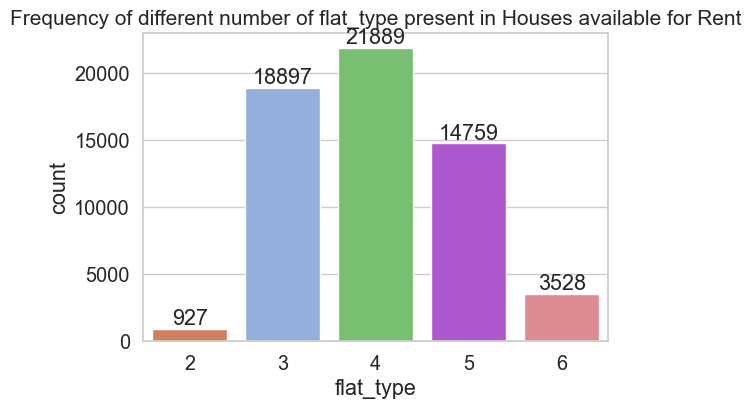

In [69]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(6,4))
colors = ['#87ace8','#e3784d', '#6ecc64','#b644e3','#eb7c87']

ax = sns.countplot(x='flat_type',data=train_data, palette=['#e3784d','#87ace8', '#6ecc64','#b644e3','#eb7c87'])
for container in ax.containers:
    ax.bar_label(container)
plt.title('Frequency of different number of flat_type present in Houses available for Rent',fontsize=15)
plt.show()

Categorical - flat_model

In [70]:
# train_data['flat_model'].value_counts()

In [71]:
# flat_model_counts = train_data['flat_model'].value_counts()

# # Plotting
# plt.figure(figsize=(15,6))  # Adjust the figure size
# sns.barplot(y=flat_model_counts.index, x=flat_model_counts.values, palette='viridis')  # Use y for town names to get a horizontal bar plot

# # Add titles and labels
# plt.title('Number of Occurrences by Flat Model')
# plt.xlabel('Number of Occurrences')
# plt.ylabel('Flat Model')

# # Display the plot
# plt.tight_layout()
# plt.show()

Categorical - furnished

In [72]:
# train_data['furnished'].value_counts()

Categorical - latitude & longitude

In [73]:
# latitude = train_data['latitude']
# longitude = train_data['longitude']

# avg_lat, avg_lon = latitude.mean(), longitude.mean()

# # Create a base map
# m = folium.Map(location=[avg_lat, avg_lon], zoom_start=12)

# # Add the heat map
# heat_data = [[lat, lon] for lat, lon in zip(train_data['latitude'], train_data['longitude'])]
# HeatMap(heat_data).add_to(m)

# # Display the map
# m

Categorical - subzone

In [74]:
# train_data['subzone'].value_counts()

Categorical - region

In [75]:
# train_data['region'].value_counts()

**Observation**
* town & planning_area: these two features' value overlaps, and there are 3 extra values in planning_area. **binary encoded** with other geographical features?
* flat_type: 4/3/5 rooms are most popular, does that mean sufficient **demand or supply**? (may influence price)
* furnished - 100% furnished, can we drop this feature?
* latitude & longitude - there are actually **naturally formed groups**, how to group them properly?
* subzone - maybe can be used with the latitude * longitude?
* region - 5 disctince values, correspond to the heat map

Numerical - monthly_rent

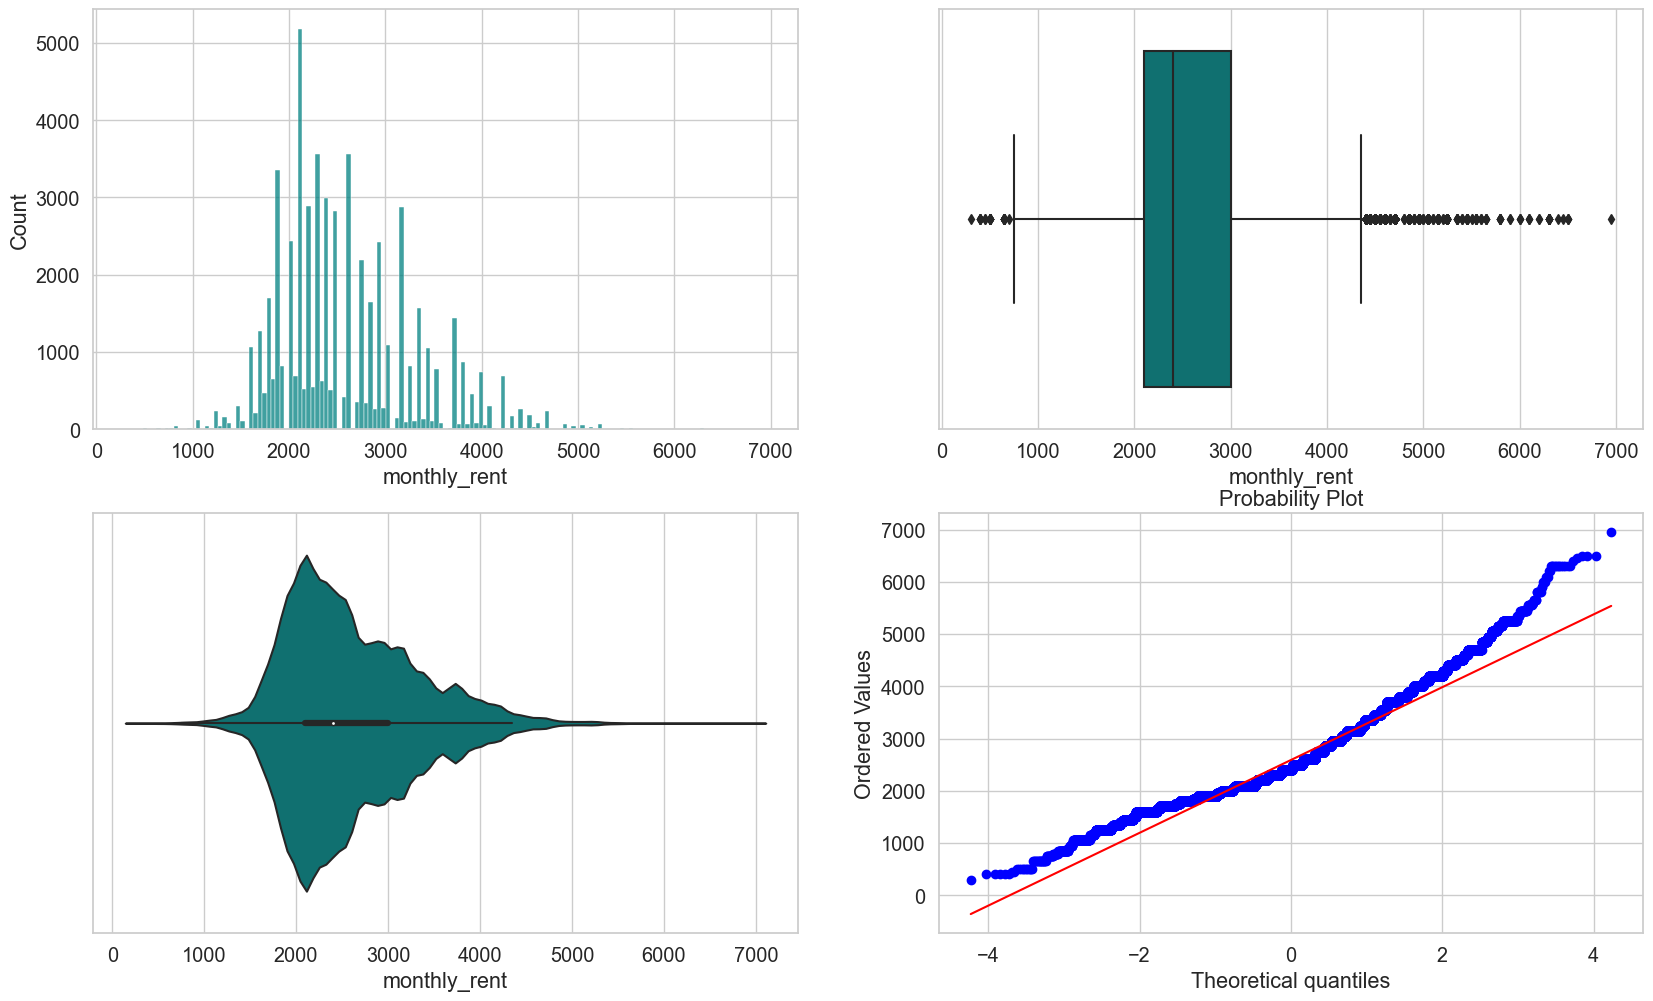

In [76]:
fig, ax = plt.subplots(2, 2, figsize=(20, 12))
ax1 = sns.histplot(x = train_data['monthly_rent'], color='teal', ax= ax[0, 0])
ax2 = sns.boxplot(x = train_data['monthly_rent'], ax= ax[0, 1], color= 'teal')
ax3 = sns.violinplot(x = train_data['monthly_rent'], ax= ax[1, 0], color= 'teal')
ax4 = probplot(train_data['monthly_rent'], plot=pylab)
pylab.show()

In [77]:
# sns.set_context('notebook', font_scale = 1.3)
# plt.figure(figsize=(15, 4))
# ax = sns.barplot(x=train_data['region'], 
#                  y=train_data['monthly_rent'], 
#                  palette='viridis',
#                  ci = None)
# plt.ylabel('Monthly Rent');

# for p in ax.patches:
#     ax.annotate(int(p.get_height()), (p.get_x() + 0.4, p.get_height() + 1), ha = 'center', va = 'bottom', color = 'Black')

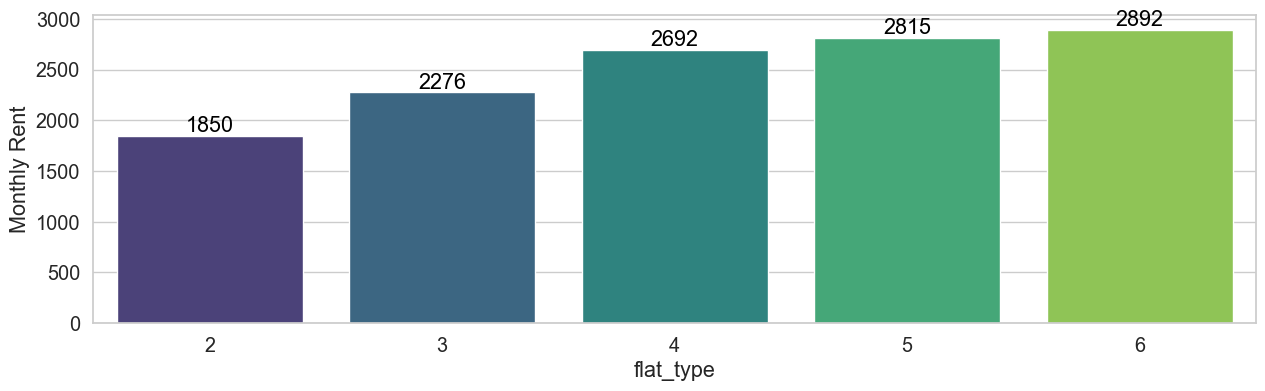

In [78]:
sns.set_context('notebook', font_scale = 1.3)
plt.figure(figsize=(15, 4))
ax = sns.barplot(x=train_data['flat_type'], 
                 y=train_data['monthly_rent'], 
                 palette='viridis',
                 ci = None)
plt.ylabel('Monthly Rent');

for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x() + 0.4, p.get_height() + 1), ha = 'center', va = 'bottom', color = 'Black')

In [79]:
# sns.set_context('notebook', font_scale = 1.3)
# plt.figure(figsize=(15, 4))
# ax = sns.barplot(x=train_data['flat_model'], 
#                  y=train_data['monthly_rent'], 
#                  palette='viridis',
#                  ci = None)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
# plt.ylabel('Monthly Rent');

# for p in ax.patches:
#     ax.annotate(int(p.get_height()), (p.get_x() + 0.4, p.get_height() + 1), ha = 'center', va = 'bottom', color = 'Black')

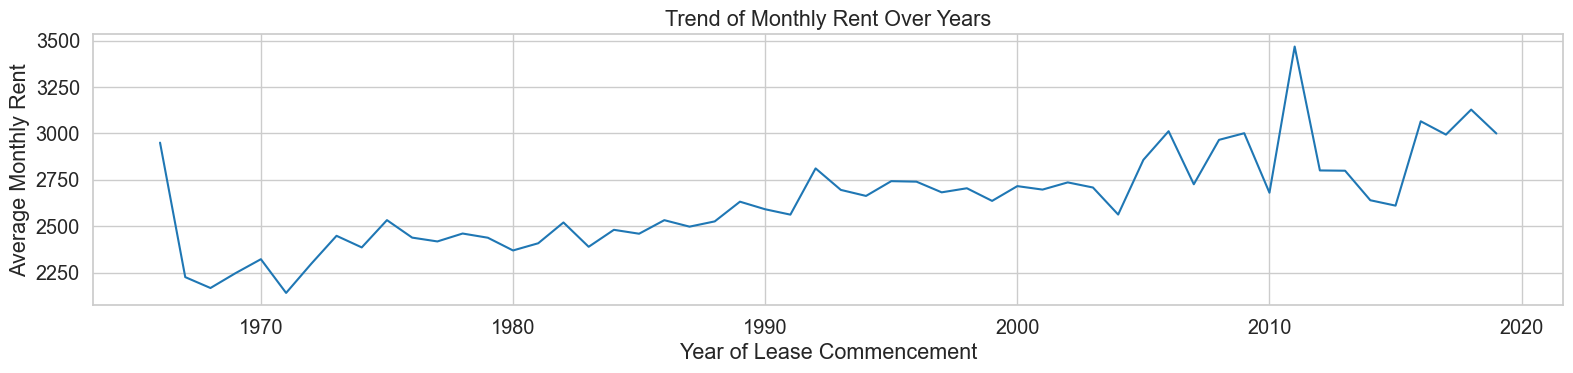

In [80]:
train_data = train_data.sort_values('lease_commence_date')

# Plot
plt.figure(figsize=(16, 4))
sns.lineplot(x='lease_commence_date', y='monthly_rent', data=train_data, ci=None)

plt.title('Trend of Monthly Rent Over Years')
plt.xlabel('Year of Lease Commencement')
plt.ylabel('Average Monthly Rent')
plt.tight_layout()
plt.show()


Numerical - floor_area_sqm

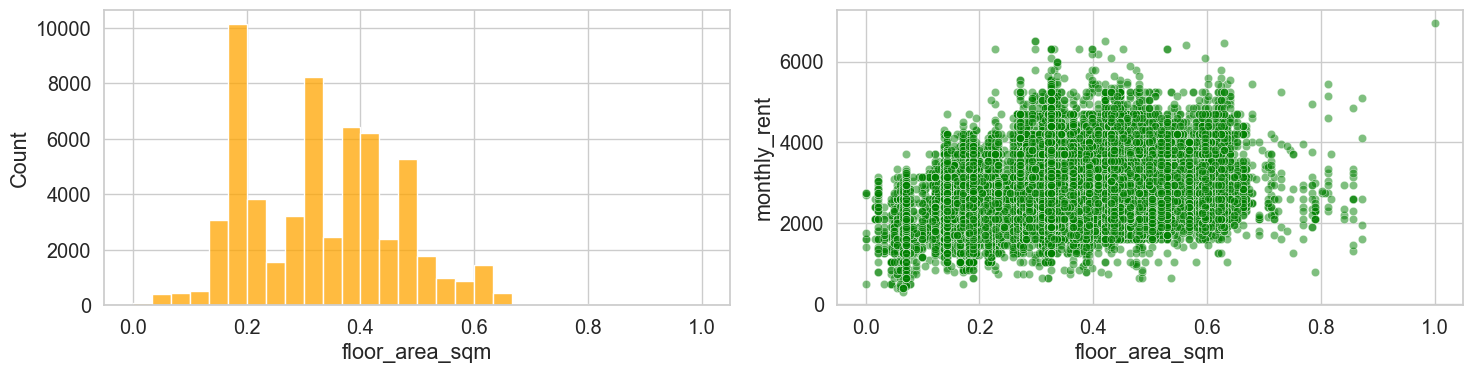

In [81]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

sns.histplot(train_data['floor_area_sqm'], bins=30, kde=False, color='orange', ax=ax[0])  # Adjust position as desired
sns.scatterplot(x=train_data['floor_area_sqm'], y=train_data['monthly_rent'], ax=ax[1], color='green', alpha=0.5)  # Adjust position as desired

plt.tight_layout()
plt.show()

Monthly rent in the map

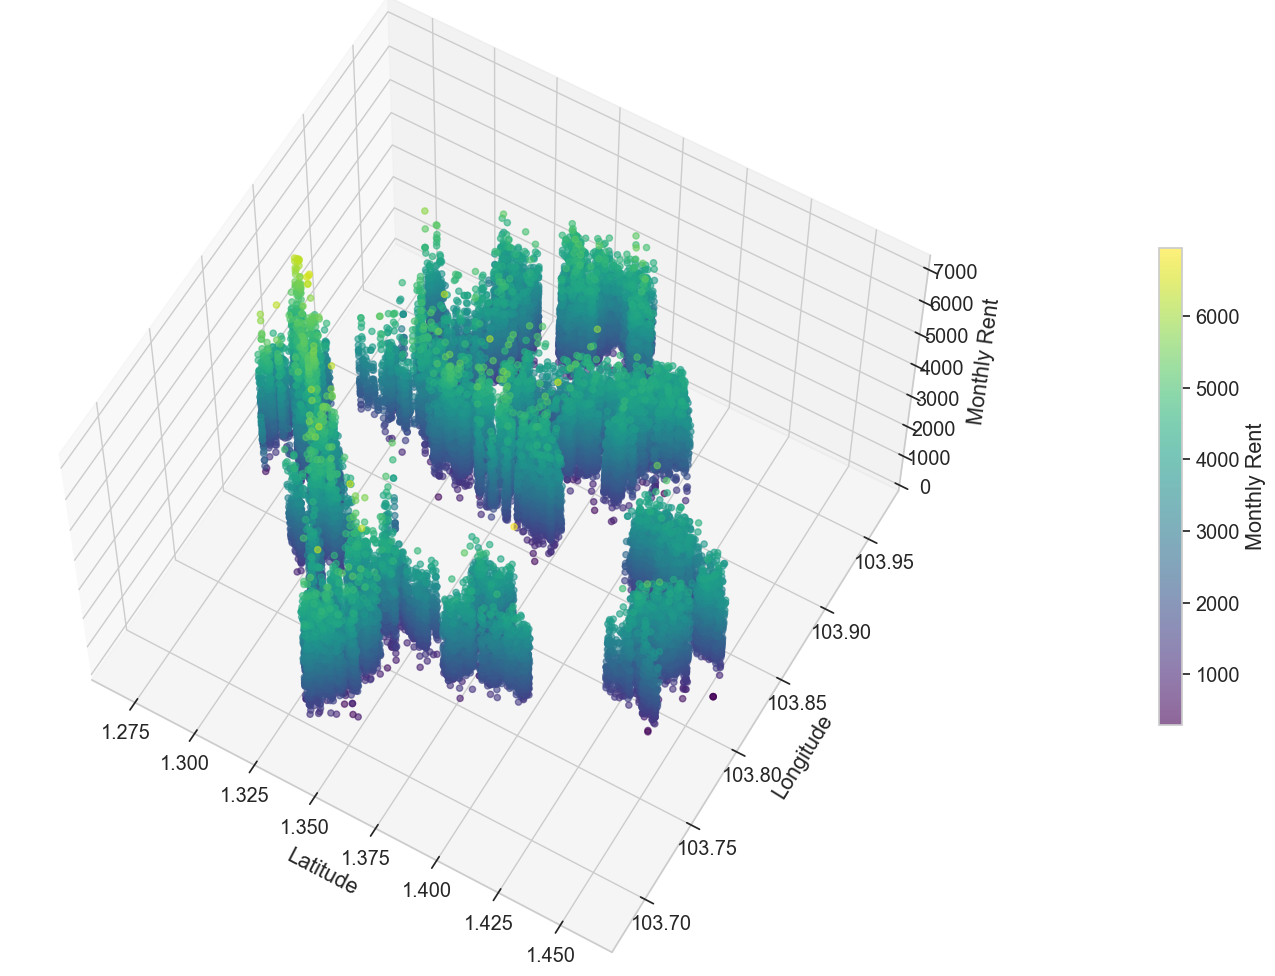

In [82]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')

x = train_data['latitude']
y = train_data['longitude']
z = train_data['monthly_rent']

scatter = ax.scatter(x, y, z, c=z, marker='o', alpha=0.6, cmap="viridis")
ax.set_xlabel('Latitude', labelpad=10) 
ax.set_ylabel('Longitude', labelpad=10) 
ax.set_zlabel('Monthly Rent', labelpad=10)
fig.colorbar(scatter, ax=ax, label='Monthly Rent', pad=0.1, shrink=0.5) 

ax.view_init(elev=60, azim=-60)  # Adjust elevation & azimuthal angles as needed

plt.tight_layout()
plt.show()

In [83]:
# train_data['town'].value_counts()

In [84]:
import plotly.express as px

fig = px.scatter_3d(train_data, 
                    x='latitude', 
                    y='longitude', 
                    z='monthly_rent',
                    color='monthly_rent', 
                    opacity=0.6,
                    color_continuous_scale='viridis',
                    title="3D Scatter plot of Rent based on Latitude and Longitude")

fig.show()

**Observation**
1. monthly rent
* it's not heavily skewed, but there are definately outliers 
* regions - the average rent across different regions are roughly the same
* flat_type - the average rent is positively correlated to the #room
* flat_model - those with extremely low frequency in flat_model usually have a high price 
* lease_commence_date - graph indicates the rent is increasing yearly, and exhibit up and downs in each decade. this can be combined with the auxiliary data to analyze the influence of economics
* floor_area_sqm - generally normal distribution, but obvious outliers
* latitude&longitude - observe from a higher angle, there are definately groups

# 4. Methods - Regression Models

After EDA and data preprocessing, we can now apply data mining methods for prediction. In this section, we choose different algorithms to generate regression models, including Multiple Linear Regression, Random Forest, XGBoost and LightGBM. The general proposal is to split the preprocessed dataset into train/test data, train and validate with train data, and evaluate the optimized model performance with test data. Finally, compare the models to get a overall picture of how well these regression models perform.

Different modelling methods may involve different data processing and feature engineering techniques. Therefore, instead of using the train_data/test_data directly, we create separate copies of the dataset for each method to generate the corresponding training/testing data for that particular method.

## 4.1 Multiple Linear Regression

In [385]:
# train_data_mlr = train_data.copy()

In [386]:
# X_train = train_data_mlr.drop(['monthly_rent'], axis = 1)
# y_train = train_data_mlr['monthly_rent']
# # X_test = test_data_mlr.drop(['monthly_rent'], axis = 1)
# # y_test = test_data_mlr['monthly_rent']

### Model Training

In [387]:
# from sklearn.linear_model import LinearRegression

In [388]:
# # Instantiate a Linear Regression model, for simplicity here we first take all attributes into consideration
# mlr = LinearRegression()
# mlr.fit(X_train, y_train)

### Evaluation

#### Evaluate the model on training dataset

We first use metrics to evaluate the model performance on the training dataset.

In [389]:
# y_pred_train = mlr.predict(X_train)

In [390]:
# # Model evaluation metrics
# print('R^2:',metrics.r2_score(y_train, y_pred_train))
# print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
# print('MAE:',metrics.mean_absolute_error(y_train, y_pred_train))
# print('MSE:',metrics.mean_squared_error(y_train, y_pred_train))
# print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))

In [391]:
# # Visualizing
# plt.scatter(y_train, y_pred_train)
# plt.xlabel("Actual Price")
# plt.ylabel("Predicted Price")
# plt.title("Actual vs Predicted")
# plt.show()

**Assumptions on MLR Models**

There are some main assumptions on Multiple Regression Models, which are listed below:

* Linearity
* No Multi-Collinearity
* Homoskedasticity
* Independence of independent variable
* Normality
* Independence of errors

We should conduct examinations on whether the assumptions above are satisfied in this context. Basic methods include using diagnostic plots for the relevant analysis. For example, we can use residual plots to check if homoskedasticity is violated or the errors' independency. Also, scatter plots of dependent versus independent variables can help us find non-linear relationships and so on.

* **Linearity**

Linearity in MLR means that the relationship between the independent variables (features) and the dependent variable (target) is linear.

In [392]:
# X_train.columns

In [393]:
# numerical_attributes = ['floor_area_sqm', 'latitude', 'longitude']
# X_plot = X_train.loc[:,numerical_attributes]
# fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(12, 4))

# axs = axs.flatten()
# for i, k in enumerate(numerical_attributes):
#     sns.regplot(y=y_train, x=X_plot[k], ax=axs[i], scatter_kws={"color": "teal"}, line_kws={"color": "red"})
# plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

* **No Multi-Collinearity**

Multicollinearity occurs when two or more independent variables in the MLR model are highly correlated, making it difficult to separate their individual effects on the dependent variable. It can impact the reliability of your regression model's coefficients and predictions. 

We use the Correlation Matrix to have a look at the multi-collinearity across all variables first. Look for high correlation coefficients (typically greater than 0.7) between pairs of variables. High correlations suggest multicollinearity.

In [394]:
# # Display Correlation Matrix
# corrMatrix = X_train.corr()
# sns.heatmap(corrMatrix, annot=True)
# plt.show()

`flat_type` and `floor_area_sqm` has a correlation coefficient of 0.95, and `town` and `planning_area` has a correlation coefficient of 0.97. This may suggest multicollinearity.

Note that `flat_type`, `town` and `planning_area` are  encoded and is not numeric values by nature, so we may consider other encoding methods for avoiding multi-collinearity across the variables.

Then we use another metrics Variance Inflation Factor (VIF) to measure how much the variance of the estimated regression coefficients is increased due to multi-collinearity. Calculate the VIF for each independent variable. High VIF values (typically greater than 10) indicate multicollinearity.

In [395]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor

In [396]:
# def calc_vif(X):
#     vif = pd.DataFrame()
#     vif["variables"] = X.columns
#     vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
#     return(vif)

In [397]:
# calc_vif(X_train)
## DOES NOT WORK 
## Ensure that the input data you're using with the isfinite function is of a numeric data type (e.g., float, int) because isfinite is typically used to check the finiteness of numeric values. If your data contains non-numeric or incompatible data types, you'll encounter this error.

* **Homoskedasticity**

Homoscedasticity means that the variance of the residuals (the differences between the observed values and the predicted values) is constant across all levels of the independent variables. If homoscedasticity is violated, it can lead to problems such as biased coefficient estimates and incorrect inference.

In [398]:
# plt.scatter(y_pred_train, y_train - y_pred_train)
# plt.title("Residual vs Fit Plot")
# plt.xlabel("Predicted")
# plt.ylabel("Residuals")
# plt.show()

We can observe that there is a random scattering of points with no discernible pattern. As in a homoskedastic dataset, the points should be evenly scattered around the horizontal line at 0 (the residuals have constant variance), we can come to the conclusion that the Homoskedasticity is not violated.

Also, we do not observe a funnel-shaped, fan-shaped pattern, or any other systematic change in the spread of residuals as the fitted values change, which suggests heteroskedasticity (the variance of residuals is not constant).

* **Independence of independent variables**

MLR assumes that independent variables are not perfectly correlated with each other (i.e., they are independent). Violations of this assumption can lead to unstable coefficient estimates and difficulties in interpreting their individual effects.

In [399]:
# # Independence of X variables-'floor_area_sqm'
# plt.scatter(X_train['floor_area_sqm'], y_train - y_pred_train)
# plt.title("Floor Area Size vs Residuals")
# plt.xlabel("floor_area_sqm")
# plt.ylabel("Residuals")
# plt.show()

In [400]:
# # Independence of X variables-'latitude'
# plt.scatter(X_train['latitude'], y_train - y_pred_train)
# plt.title("Latitude vs Residuals")
# plt.xlabel("latitude")
# plt.ylabel("Residuals")
# plt.show()

In [401]:
# # Independence of X variables-'longitude'
# plt.scatter(X_train['longitude'], y_train - y_pred_train)
# plt.title("Longitude vs Residuals")
# plt.xlabel("latitude")
# plt.ylabel("Residuals")
# plt.show()

The plots above all show that residuals do appear randomly and symmetrically distributed around zero under all conditions, which prove the independence.

* **Normality**

MLR assumes that the residuals (the differences between the observed and predicted values) are normally distributed. Deviations from normality can impact the validity of statistical inference, such as hypothesis tests and confidence intervals.

In [402]:
# # Normality of residuals
# sns.distplot(y_train - y_pred_train)
# plt.title("Normality of Residuals")
# plt.xlabel("Residuals")
# plt.ylabel("Frequency")
# plt.show()

We can see fro the plot above that the residuals are normally distributed, which means the normality assumption is satiefied.

* **Independence of errors**

Independence of errors states that the residuals (the differences between the observed values and the predicted values) should be independent of each other. Violations of this assumption can lead to incorrect parameter estimates, unreliable hypothesis tests, and inaccurate predictions. 

Here we use *Durbin-Watson Test* for checking independence of errors. This statistical test checks for the presence of autocorrelation in the residuals. A Durbin-Watson statistic value close to 2 indicates no autocorrelation.

In [403]:
# durbin_watson_statistic = sm.stats.stattools.durbin_watson(y_train - y_pred_train)
# print(f'Durbin-Watson Statistic: {durbin_watson_statistic}')

The Durbin-Watson statistic value is close to 2, which means there is no autocorrelation (i.e. the assmuption is satisfied).

#### Evaluate the model on test dataset

After the evalution on the training dataset, as well as the checks for MLR assmuptions and corresponding model refinement, we can use the model as the final  MLR model and evaluate its performance on the test dataset.

In [404]:
# y_pred_test = mlr.predict(X_test)

In [405]:
# mlr_dict = {'Model':'Multiple Linear Regression',
#           'R^2':metrics.r2_score(y_test, y_pred_test),
#           'Adjusted R^2':(1 - (1-metrics.r2_score(y_test, y_pred_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)),
#           'MAE':metrics.mean_absolute_error(y_test, y_pred_test),
#           'MSE':metrics.mean_squared_error(y_test, y_pred_test),
#           'RMSE':np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))}

# mlr_metrics = pd.DataFrame.from_dict(mlr_dict, orient = 'index').T

# # Display model performance metrics
# mlr_metrics

### Analysis

> TODO

</br>

## 4.2 Random Forest Regressor

In [406]:
# train_data_rf = train_data.copy()
# # test_data_rf = test_data.copy()

In [407]:
# X_train = train_data_rf.drop(['monthly_rent'], axis = 1)
# y_train = train_data_rf['monthly_rent']
# # X_test = test_data_mlr.drop(['monthly_rent'], axis = 1)
# # y_test = test_data_mlr['monthly_rent']

### Model Training

In [408]:
# from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# from sklearn.ensemble import RandomForestRegressor

We use GridSearchCV as a technique to systematically search through different combinations of hyperparameters to find the best set of hyperparameters for RF model.

In [409]:
# rf_param_grid = {
#     'max_depth': [90, 100], # Maximum number of levels in each decision tree
# #     'max_depth': [80, 90, 100],
#     'max_features': [2, 3], # Maximum number of features considered for splitting a node
#     'min_samples_leaf': [1, 3], # Minimum number of data points allowed in a leaf node
# #     'min_samples_leaf': [1, 3, 4, 5],
#     'n_estimators': [300, 600] # Number of trees in the forest
# #     'n_estimators': [100, 300, 600]
# }

In [410]:
# rf_reg = RandomForestRegressor(random_state = 42)
# rf_grid = GridSearchCV(estimator = rf_reg, param_grid = rf_param_grid, cv=5, n_jobs=-1, verbose=2)

In [411]:
# rf_grid.fit(X_train, y_train)

In [412]:
# rf_grid.best_params_

In [413]:
# # Get best RF estimator based on best parameters gemerated from above
# rf = rf_grid.best_estimator_

### Evaluation

#### Evaluate the model on training dataset

We first use metrics to evaluate the model performance on the training dataset.

In [414]:
# # Use RF regressor to predict on training set
# y_pred_train = rf.predict(X_train)

In [415]:
# # Model evaluation metrics
# print('R^2:',metrics.r2_score(y_train, y_pred_train))
# print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
# print('MAE:',metrics.mean_absolute_error(y_train, y_pred_train))
# print('MSE:',metrics.mean_squared_error(y_train, y_pred_train))
# print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))

#### Evaluate the model on testing dataset

In [416]:
# y_pred_test = rf.predict(X_test)

In [417]:
# rf_dict = {'Model':'Random Forest Regressor',
#           'R^2':metrics.r2_score(y_test, y_pred_test),
#           'Adjusted R^2':(1 - (1-metrics.r2_score(y_test, y_pred_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)),
#           'MAE':metrics.mean_absolute_error(y_test, y_pred_test),
#           'MSE':metrics.mean_squared_error(y_test, y_pred_test),
#           'RMSE':np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))}

# rf_metrics = pd.DataFrame.from_dict(rf_dict, orient = 'index').T

# # Display model performance metrics
# rf_metrics

### Analysis

* **Importance of the features**

In [418]:
# rf.feature_importances_

In [419]:
# rf_features = pd.DataFrame([X_train.columns, rf.feature_importances_]).T
# rf_features = rf_features.rename(columns={0: 'Feature', 1: 'Importance Score'})
# rf_features.sort_values(by = 'Importance Score', ascending = False)

</br>

## 4.3 XGBoost Regressor

In [420]:
# train_data_rf = train_data.copy()
# # test_data_rf = test_data.copy()

In [421]:
# X_train = train_data_rf.drop(['monthly_rent'], axis = 1)
# y_train = train_data_rf['monthly_rent']
# # X_test = test_data_mlr.drop(['monthly_rent'], axis = 1)
# # y_test = test_data_mlr['monthly_rent']

### Model Training

In [422]:
# import xgboost as xgb
# from xgboost import plot_importance

In [423]:
# xgb_param_grid = {"learning_rate": [0.05, 0.1, 0.2], # Step size shrinkage used in update to prevents overfitting.
#                   "max_depth"        : [6, 8, 9, 10], # Maximum depth of a tree. 
#                   "min_child_weight" : [1, 3, 5, 7], # Minimum number of instances required in a child node
#                   "gamma"            : [0.0, 0.1, 0.2, 0.3], # Minimum loss reduction required to make a further partition on a leaf node of the tree.
#                   "colsample_bytree" : [0.3, 0.4, 0.6, 0.8] # Number of features supplied to a tree
# }

In [424]:
# xgb_reg = xgb.XGBRegressor(seed = 42, objective ='reg:squarederror')
# xgb_grid = GridSearchCV(estimator = xgb_reg, param_grid = xgb_param_grid, cv=5, n_jobs=-1, verbose=2)

**TO BE CHECKED!!! Failed**

In [425]:
# xgb_grid.fit(X_train, y_train)

In [426]:
# xgb_grid.best_params_

In [427]:
# Get best XGBoost estimator based on best parameters gemerated from above
# xgb = xgb_grid.best_estimator_

### Evaluation

#### Evaluate the model on training dataset

We first use metrics to evaluate the model performance on the training dataset.

In [428]:
# # Use XGBoost regressor to predict on training set
# y_pred_train = xgb.predict(X_train)

In [429]:
# # Model evaluation metrics
# print('R^2:',metrics.r2_score(y_train, y_pred_train))
# print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
# print('MAE:',metrics.mean_absolute_error(y_train, y_pred_train))
# print('MSE:',metrics.mean_squared_error(y_train, y_pred_train))
# print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))

#### Evaluate the model on testing dataset

In [430]:
# y_pred_test = xgb.predict(X_test)

In [431]:
# xgb_dict = {'Model':'XGBoost Regressor',
#           'R^2':metrics.r2_score(y_test, y_pred_test),
#           'Adjusted R^2':(1 - (1-metrics.r2_score(y_test, y_pred_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)),
#           'MAE':metrics.mean_absolute_error(y_test, y_pred_test),
#           'MSE':metrics.mean_squared_error(y_test, y_pred_test),
#           'RMSE':np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))}

# xgb_metrics = pd.DataFrame.from_dict(xgb_dict, orient = 'index').T

# # Display model performance metrics
# xgb_metrics

### Analysis

* **Importance of the features**

In [432]:
# xgb_features = pd.DataFrame([X_train.columns, xgb.feature_importances_]).T
# xgb_features = xgb_features.rename(columns={0: 'Feature', 1: 'Importance Score'})
# xgb_features.sort_values(by = 'Importance Score', ascending = False).head(15)

In [433]:
# plot_importance(xgb, max_num_features = 10)

</br>

## 4.4 LightGBM Regressor

In [434]:
# train_data_rf = train_data.copy()
# # test_data_rf = test_data.copy()

In [435]:
# X_train = train_data_rf.drop(['monthly_rent'], axis = 1)
# y_train = train_data_rf['monthly_rent']
# # X_test = test_data_mlr.drop(['monthly_rent'], axis = 1)
# # y_test = test_data_mlr['monthly_rent']

#### Model Training

In [436]:
# import lightgbm as lgb

In [437]:
# gbm_param_grid = {'metric': ['rmse'],
#                   'max_depth': [9,10,11,12,13], 
#                   'bagging_fraction': [0.8, 0.9, 1],
#                   'feature_fraction': [0.8, 0.9, 1],
#                   'min_data_in_leaf': [20,50,80],
#                   'learning_rate': [0.01,0.05,0.1,0.2]}

In [438]:
# lgb_reg = lgb.LGBMRegressor(seed = 42, num_iterations = 1200)

# lgb_grid = GridSearchCV(estimator = lgb_reg, param_grid = gbm_param_grid, cv=5, n_jobs=-1, verbose=1)

**TO BE CHECKED**

In [439]:
#lgb_grid.fit(X_train, y_train)

## 5. Model Comparison

In [440]:
# df_metrics = pd.concat([mlr_metrics, rf_metrics, xgb_metrics, lgbm_metrics])
# df_metrics.sort_values(by = 'RMSE', ascending = True)

See from the metrics comparison above, XXXXXXX achieves the best performance on the test set with an RMSE of XXXXXXX. 

# 5. Ensemble Models

5.1 Baseline

In [441]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import ParameterGrid, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import RidgeCV, ElasticNetCV, LassoCV, Lasso, ElasticNet, Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgb
from mlxtend.regressor import StackingCVRegressor

In [442]:
# *******************Linear model*******************
def get_model():
    net = nn.Sequential(nn.Linear(in_features, 64),
                        nn.ReLU(),
                        nn.Linear(64, 32),
                        nn.ReLU(),
                        nn.Linear(32, 1),)
    return net

def log_rmse(net, features, labels):
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # Adam optimization
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_model()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_model()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    preds = net(test_features).detach().numpy()
    df_id = pd.DataFrame([id for id in range(test_data.shape[0])], columns=['Id'])
    test_data['Predicted'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([df_id['Id'], test_data['Predicted']], axis=1)
    return submission, train_ls

In [443]:
train_data.reset_index(drop=True, inplace=True)
train_data.head()

rent_approval_date  town_0  town_1  town_2  town_3  town_4  block_0  \
0         2023-01-01       0       0       0       0       1        0   
1         2022-07-01       1       0       0       0       1        0   
2         2021-07-01       1       0       1       1       0        0   
3         2021-07-01       0       0       0       1       1        0   
4         2021-02-01       1       0       0       0       1        0   

   block_1  block_2  block_3  ...  planning_area_2  planning_area_3  \
0        0        0        0  ...                0                0   
1        0        1        0  ...                0                0   
2        0        1        0  ...                1                1   
3        0        0        0  ...                0                1   
4        0        1        0  ...                0                0   

   planning_area_4  region_0  region_1  region_2  monthly_rent  latitude_norm  \
0                1         0         0         1          2950       0.271538   
1                1         0         1         1          2250       0.181267   
2                0         0         1         1          2100       0.303198   
3                1         0         1         1          2100       0.381238   
4                1         0         1         1          1450       0.181267   

   longitude_norm  monthly_rent_norm  
0        0.206582           0.398496  
1        0.411788           0.293233  
2        0.721950           0.270677  
3        0.573002           0.270677  
4        0.411788           0.172932  

[5 rows x 59 columns]

In [444]:
train_len = train_data.shape[0] * 0.8
numeric_attributes=['flat_type', 'floor_area_sqm', 'latitude', 'longitude']
train_data_linear = train_data.loc[:train_len-1,numeric_attributes]
train_data_rent = train_data.loc[:train_len-1,['monthly_rent']]
train_data_rent.shape

(48000, 1)

In [445]:
test_data_linear = train_data.loc[train_len:,numeric_attributes]
test_data_linear.head()
print(train_data_linear.shape, test_data_linear.shape)

(48000, 4) (12000, 4)


In [446]:
train_attributes = torch.tensor(train_data_linear.values, dtype=torch.float32)
test_attributes = torch.tensor(test_data_linear.values, dtype=torch.float32)
train_labels_linear = torch.tensor(train_data_rent.values.reshape(-1, 1), dtype=torch.float32)
loss = nn.MSELoss()
in_features = train_attributes.shape[1]

fold 1, train log rmse 0.235851, valid log rmse 0.239425
fold 2, train log rmse 0.237359, valid log rmse 0.230051
fold 3, train log rmse 0.239921, valid log rmse 0.236837
fold 4, train log rmse 0.235613, valid log rmse 0.240613
fold 5, train log rmse 0.235692, valid log rmse 0.237769
5-fold cross-validation: average train log rmse: 0.236887, average test log rmse: 0.236939


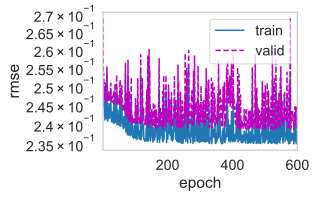

In [447]:
# train linear model
k, num_epochs, lr, weight_decay, batch_size = 5, 600, 0.01, 0, 64 # adjust hyperparameter
train_l, valid_l = k_fold(k, train_attributes, train_labels_linear, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-fold cross-validation: average train log rmse: {float(train_l):f}, '
      f'average test log rmse: {float(valid_l):f}')

train log rmse 0.238531


OSError: Cannot save file into a non-existent directory: '\result'

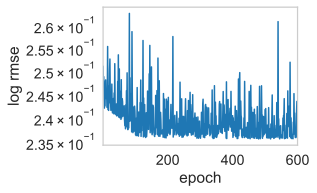

In [448]:
# predict linear model
submission, train_ls = train_and_pred(train_attributes, test_attributes, train_labels_linear, test_data,
               num_epochs, lr, weight_decay, batch_size)
# score = self_evaluation(submission)


In [450]:
submission.to_csv('result/submission_linear_rmsle'+str(float(train_ls[-1]))[:6]+'.csv', index=False)

In [453]:
# Define error metrics
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

# k-fold Cross Validation
# set verbose=3 for more details
def rmsle_cross_val(X_train, y_train, n_folds, model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
    rmse= np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return rmse

kfolds = KFold(n_splits=5, shuffle=True, random_state=42)

In [454]:
# *******************Lasso model*******************
# lasso_alphas = [0.00001, 0.00005, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005]
# model_lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1000,alphas =lasso_alphas, random_state=42, cv=kfolds))
# model_lasso = make_pipeline(RobustScaler(), Lasso(max_iter=1000, alpha =0.00005, random_state=42))
model_lasso = Lasso(max_iter=1000, alpha =0.00005, tol=0.1, random_state=42)
score_lasso = rmsle_cross_val(train_data_linear, train_data_rent, 5, model_lasso)
print("Lasso score: {:.4f} ({:.4f})\n".format(score_lasso.mean(), score_lasso.std()))
model_lasso.fit(train_data_linear.values, train_data_rent.values)
model_lasso_pred = model_lasso.predict(test_data_linear.values)
df_id = pd.DataFrame([id for id in range(test_data.shape[0])], columns=['Id'])
df_pred = pd.DataFrame(pd.Series(model_lasso_pred), columns = ['Predicted'])
model_lasso_pred, df_pred['Predicted']
submission = pd.concat([df_id['Id'], df_pred['Predicted']], axis=1)
# self_evaluation(submission)
submission.to_csv('result/submission_lasso_rmse'+str(float(score_lasso.mean()))[:7]+'.csv', index=False)

Lasso score: 628.9685 (35.9875)


In [455]:
# *******************ENet model*******************
# enet_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
# enet_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]
model_ENet = make_pipeline(RobustScaler(), ElasticNet(max_iter=3000, alpha=0.0005, l1_ratio=0.8, tol=0.2, random_state=42))
score_ENet = rmsle_cross_val(train_data_linear, train_data_rent, 5, model_ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score_ENet.mean(), score_ENet.std()))
model_ENet.fit(train_data_linear.values, train_data_rent.values)
model_ENet_pred = model_ENet.predict(test_data_linear.values)
df_id = pd.DataFrame([id for id in range(test_data.shape[0])], columns=['Id'])
df_pred = pd.DataFrame(pd.Series(model_ENet_pred), columns = ['Predicted'])
submission = pd.concat([df_id['Id'], df_pred['Predicted']], axis=1)
# self_evaluation(submission)
submission.to_csv('result/submission_enet_rmse'+str(float(score_ENet.mean()))[:7]+'.csv', index=False)

ElasticNet score: 628.9657 (35.9864)


In [456]:
# *******************Ridge model*******************
ridge_alphas = [1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
model_ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kfolds))
# model_ridge = make_pipeline(RobustScaler(), Ridge(max_iter=1000, alpha=0.1))
score_ridge = rmsle_cross_val(train_data_linear, train_data_rent, 5, model_ridge)
print("Ridge score: {:.4f} ({:.4f})\n".format(score_ridge.mean(), score_ridge.std()))
model_ridge.fit(train_data_linear.values, train_data_rent.values)
model_ridge_pred = model_ENet.predict(test_data_linear.values)
df_id = pd.DataFrame([id for id in range(test_data.shape[0])], columns=['Id'])
df_pred = pd.DataFrame(pd.Series(model_ridge_pred), columns = ['Predicted'])
submission = pd.concat([df_id['Id'], df_pred['Predicted']], axis=1)
# self_evaluation(submission)
submission.to_csv('result/submission_ridge_rmse'+str(float(score_ridge.mean()))[:7]+'.csv', index=False)

Ridge score: 628.9565 (35.9528)


In [457]:
# *******************SVR model*******************
# C = [0.1, 0.5, 1, 50, 100, 1000]
# epsilon = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]
# C:5 - 0.1163 (0.0032), C:10 - 0.1140 (0.0034), epsilon: 0.05 - 0.1105 (0.0039)
model_svr = make_pipeline(RobustScaler(), SVR(C=10, epsilon=0.05, gamma='scale'))
score_svr = rmsle_cross_val(train_data_linear, np.log(train_data_rent), 5, model_svr)
print("SVR score: {:.4f} ({:.4f})\n".format(score_svr.mean(), score_svr.std()))

model_svr.fit(train_data_linear.values, np.log(train_data_rent.values))
model_svr_pred = model_svr.predict(test_data_linear.values)
df_id = pd.DataFrame([id for id in range(test_data.shape[0])], columns=['Id'])
df_pred = pd.DataFrame(pd.Series(np.exp(model_svr_pred)), columns = ['Predicted'])
submission = pd.concat([df_id['Id'], df_pred['Predicted']], axis=1)
# self_evaluation(submission)
submission.to_csv('result/submission_svr_rmsle'+str(float(score_svr.mean()))[:7]+'.csv', index=False)

SVR score: 0.2407 (0.0083)


In [458]:
test_data.head()

rent_approval_date  town_0  town_1  town_2  town_3  town_4  block_0  \
0         2023-01-01       1       0       1       1       1        0   
1         2022-09-01       0       1       1       1       0        0   
2         2023-07-01       0       1       1       0       0        0   
3         2021-08-01       0       0       0       0       1        0   
4         2022-03-01       0       0       0       0       1        0   

   block_1  block_2  block_3  ...  planning_area_3  planning_area_4  region_0  \
0        0        0        0  ...                1                1         1   
1        0        0        0  ...                1                0         1   
2        0        0        0  ...                0                0         0   
3        1        0        1  ...                0                1         0   
4        0        1        1  ...                0                1         0   

   region_1  region_2  monthly_rent  latitude_norm  longitude_norm  \
0         0         0             0       0.471535        0.738302   
1         0         1             0       0.942534        0.484785   
2         0         1             0       0.189292        0.275091   
3         0         1             0       0.398801        0.162860   
4         0         1             0       0.402037        0.178815   

   monthly_rent_norm    Predicted  
0          -0.045113  2878.480469  
1          -0.045113  2539.162842  
2          -0.045113  2698.632568  
3          -0.045113  2675.987061  
4          -0.045113  2563.924316  

[5 rows x 60 columns]

In [459]:
train_data.head()

rent_approval_date  town_0  town_1  town_2  town_3  town_4  block_0  \
0         2023-01-01       0       0       0       0       1        0   
1         2022-07-01       1       0       0       0       1        0   
2         2021-07-01       1       0       1       1       0        0   
3         2021-07-01       0       0       0       1       1        0   
4         2021-02-01       1       0       0       0       1        0   

   block_1  block_2  block_3  ...  planning_area_2  planning_area_3  \
0        0        0        0  ...                0                0   
1        0        1        0  ...                0                0   
2        0        1        0  ...                1                1   
3        0        0        0  ...                0                1   
4        0        1        0  ...                0                0   

   planning_area_4  region_0  region_1  region_2  monthly_rent  latitude_norm  \
0                1         0         0         1          2950       0.271538   
1                1         0         1         1          2250       0.181267   
2                0         0         1         1          2100       0.303198   
3                1         0         1         1          2100       0.381238   
4                1         0         1         1          1450       0.181267   

   longitude_norm  monthly_rent_norm  
0        0.206582           0.398496  
1        0.411788           0.293233  
2        0.721950           0.270677  
3        0.573002           0.270677  
4        0.411788           0.172932  

[5 rows x 59 columns]

In [460]:
# init train data and test data for non-linear model
all_data_ensemble = train_data.copy()
# test_data_linear = train_data.loc[train_len*0.8:,numeric_attributes]
train_data_ensemble = train_data.copy().drop(columns = ['monthly_rent'])
# test_data_ensemble = test_data.copy().drop(columns = ['Predicted'])
test_data_ensemble = test_data.copy()
train_data_rent = train_data.loc[:train_len/0.8,['monthly_rent']]
train_data_ensemble.shape, test_data_ensemble.shape

((60000, 58), (30000, 60))

In [462]:
train_data_ensemble.head()

rent_approval_date  town_0  town_1  town_2  town_3  town_4  block_0  \
0         2023-01-01       0       0       0       0       1        0   
1         2022-07-01       1       0       0       0       1        0   
2         2021-07-01       1       0       1       1       0        0   
3         2021-07-01       0       0       0       1       1        0   
4         2021-02-01       1       0       0       0       1        0   

   block_1  block_2  block_3  ...  planning_area_1  planning_area_2  \
0        0        0        0  ...                0                0   
1        0        1        0  ...                0                0   
2        0        1        0  ...                0                1   
3        0        0        0  ...                0                0   
4        0        1        0  ...                0                0   

   planning_area_3  planning_area_4  region_0  region_1  region_2  \
0                0                1         0         0         1   
1                0                1         0         1         1   
2                1                0         0         1         1   
3                1                1         0         1         1   
4                0                1         0         1         1   

   latitude_norm  longitude_norm  monthly_rent_norm  
0       0.271538        0.206582           0.398496  
1       0.181267        0.411788           0.293233  
2       0.303198        0.721950           0.270677  
3       0.381238        0.573002           0.270677  
4       0.181267        0.411788           0.172932  

[5 rows x 58 columns]

In [463]:
train_data_rent.head()

monthly_rent
0          2950
1          2250
2          2100
3          2100
4          1450

In [461]:
# *******************Random Forest model*******************
# use grid search to produce a baseline rf model
model_rf = RandomForestRegressor(oob_score=True, random_state=3, n_jobs=-1)
params ={
    'n_estimators': [1300],# [800, 900, 1000, 1200, 1500],
    'min_samples_leaf': [1],# [1, 2, 3, 5, 10, 25],
    'max_features': [0.5],# [None, 0.5, 'sqrt', 'log2'],
    'max_depth': [35],# [5, 6, 7, 8, 10, 15, 20],
    'min_samples_split': [2]# [2, 3, 4]
}

best_score = 0
for g in ParameterGrid(params):
    model_rf.set_params(**g)
    model_rf.fit(train_data_ensemble, train_data_rent)
    if model_rf.oob_score_ > best_score:
        best_score = model_rf.oob_score_
        best_grid = g
        print('oob:', best_score, best_grid)
# oob: 0.9764868974915827 {'max_depth': 35, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1300}

TypeError: The DType <class 'numpy.dtype[datetime64]'> could not be promoted by <class 'numpy.dtype[float64]'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtype[datetime64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[datetime64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>)

In [ ]:
# check feature importance
def RF_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)

model_rf = RandomForestRegressor(n_jobs=-1, n_estimators=1300, oob_score=True, max_depth=35, min_samples_leaf=1, min_samples_split=2, max_features=0.5)
model_rf.fit(train_data_ensemble, train_data_rent)
feature_imp = RF_importance(model_rf, train_data_ensemble)
print(model_rf.oob_score_)
print(feature_imp)

In [ ]:
# feature selection
Threshold = 0.0009
to_keep = feature_imp[feature_imp.imp>Threshold].cols
to_keep = [col for _, col in to_keep.items()]
print(to_keep)
df_keep = train_data_ensemble[to_keep].copy()
model_rf = RandomForestRegressor(n_jobs=-1, n_estimators=1300, oob_score=True, max_depth=35, min_samples_leaf=1, min_samples_split=2, max_features=0.5)
model_rf.fit(df_keep, train_data_rent)
score_rf = rmsle_cross_val(train_data_ensemble, train_data_rent, 5, model_rf)
print(model_rf.oob_score_, score_rf.mean())

In [ ]:
# deep selection
# keep_cols imp >= 0.01
keep_cols = ['rent_approval_date', 'latitude', 'longitude', 'floor_area_sqm', 'flat_type', 'lease_commence_date', 'flat_model', 'planning_area', 'town', 'region']
cols = to_keep
scores = []
feats = []
for col in cols:
    tmp = to_keep.copy()
    if col in keep_cols:
        continue
    tmp.remove(col)
    df_tmp = train_data_ensemble[tmp].copy()
    model_rf = RandomForestRegressor(n_jobs=-1, n_estimators=1300, oob_score=True, max_depth=35, min_samples_leaf=1, min_samples_split=2, max_features=0.5)
    model_rf.fit(df_tmp, train_data_rent)
    scores.append(model_rf.oob_score_)
    feats.append(col)

to_del = sorted(zip(scores, feats), reverse=True)
to_del

In [ ]:
# fine-tuning
# delete increase less than 0.0001
to_keep_final = ['latitude', 'lease_commence_date', 'longitude', 'flat_type', 'flat_model', 'floor_area_sqm', 
                 'rent_approval_date']
train_data_final = train_data_ensemble[to_keep_final].copy()
model_rf = RandomForestRegressor(oob_score=True, n_jobs=-1)
params ={
    'n_estimators': [1200, 1250,1280],# [1200, 1250, 1280, 1300, 1350, 1400],
    'min_samples_leaf': [1],# [1, 2, 3, 5, 10, 25],
    'max_features': [0.5],# [0.5, 'sqrt', 'log2'],
    'max_depth': [35],# [5, 6, 7, 8],
    'min_samples_split': [2]# [2, 3, 4]
}

best_score = 0
for g in ParameterGrid(params):
    model_rf.set_params(**g)
    model_rf.fit(train_data_final, train_data_rent)
    if model_rf.oob_score_ > best_score:
        score_rf = rmsle_cross_val(train_data_final, train_data_rent, 5, model_rf)
        best_score = model_rf.oob_score_
        best_grid = g
        print('best oob:', best_score, best_grid, 'score:', score_rf.mean())

In [ ]:
model_rf = RandomForestRegressor(n_jobs=-1, n_estimators=1250, max_depth=35, min_samples_leaf=1, min_samples_split=2, max_features=0.5)
model_rf.fit(train_data_final, train_data_rent)

In [ ]:
test_data_final = test_data_ensemble[to_keep_final]
# print(test_data_final)
model_rf_pred=model_rf.predict(test_data_final)
df_id = pd.DataFrame([id for id in range(test_data.shape[0])], columns=['Id'])
df_pred = pd.DataFrame(pd.Series(model_rf_pred), columns = ['Predicted'])
submission = pd.concat([df_id['Id'], df_pred['Predicted']], axis=1)
# self_evaluation(submission)
submission.to_csv('result/submission_rf_'+str(best_score)[:7]+'.csv', index=False)

In [ ]:
# *******************GBoost model*******************
model_GBoost = GradientBoostingRegressor(n_estimators=7000, learning_rate=0.1,
                                   max_depth=5, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =42)
score_GBoost = rmsle_cross_val(train_data_ensemble, np.log(train_data_rent), 5, model_GBoost)
print("GradientBoostingRegressor score: {:.4f} ({:.4f})\n".format(score_GBoost.mean(), score_GBoost.std()))

model_GBoost.fit(train_data_ensemble.values, train_data_rent.values)
model_gb_pred = model_GBoost.predict(test_data_ensemble.values)
df_id = pd.DataFrame([id for id in range(test_data.shape[0])], columns=['Id'])
df_pred = pd.DataFrame(pd.Series(model_gb_pred), columns = ['Predicted'])
submission = pd.concat([df_id['Id'], df_pred['Predicted']], axis=1)
# self_evaluation(submission)
submission.to_csv('result/submission_gb_rmsle'+str(float(score_GBoost.mean()))[:7]+'.csv', index=False)

In [ ]:
# *******************XGB model*******************
# xgb_params = dict(
#     max_depth=6,           # maximum depth of each tree - try 2 to 10
#     learning_rate=0.01,    # effect of each tree - try 0.0001 to 0.1
#     n_estimators=1000,     # number of trees (that is, boosting rounds) - try 1000 to 8000
#     min_child_weight=1,    # minimum number of houses in a leaf - try 1 to 10
#     colsample_bytree=0.7,  # fraction of features (columns) per tree - try 0.2 to 1.0
#     subsample=0.7,         # fraction of instances (rows) per tree - try 0.2 to 1.0
#     reg_alpha=0.5,         # L1 regularization (like LASSO) - try 0.0 to 10.0
#     reg_lambda=1.0,        # L2 regularization (like Ridge) - try 0.0 to 10.0
#     num_parallel_tree=1,   # set > 1 for boosted random forests
# )
model_xgb = xgb.XGBRegressor(learning_rate=0.01, gamma=0,
                             max_depth=5, min_child_weight = 1,
                             n_estimators=6000, colsample_bytree=0.6,
                             reg_alpha=0.5, reg_lambda=1.0,
                             subsample=0.7, random_state = 42, nthread = -1)
score_xgb = rmsle_cross_val(train_data_ensemble, np.log(train_data_rent), 5, model_xgb)
print("XGB score: {:.4f} ({:.4f})\n".format(score_xgb.mean(), score_xgb.std()))

model_xgb.fit(train_data_ensemble.values, train_data_rent.values)
model_xgb_pred = model_xgb.predict(test_data_ensemble.values)
df_id = pd.DataFrame([id for id in range(test_data.shape[0])], columns=['Id'])
df_pred = pd.DataFrame(pd.Series(model_xgb_pred), columns = ['Predicted'])
submission = pd.concat([df_id['Id'], df_pred['Predicted']], axis=1)
# self_evaluation(submission)
submission.to_csv('result/submission_xgb_rmsle'+str(float(score_xgb.mean()))[:7]+'.csv', index=False)

In [ ]:
# *******************LightGBM model*******************
# Use large max_bin (may be slower)
# Use small learning_rate with large num_iterations
# Use large num_leaves (may cause over-fitting)
model_lgb = lgb.LGBMRegressor(objective='regression', 
                       num_leaves=25, learning_rate=0.05, 
                       max_bin = 200, n_estimators=1000,
                       random_state=42)
score_lgb = rmsle_cross_val(train_data_ensemble, np.log(train_data_rent), 5, model_lgb)
print("LGB score: {:.4f} ({:.4f})\n".format(score_lgb.mean(), score_lgb.std()))

model_lgb.fit(train_data_ensemble.values, train_data_rent.values)
model_lgb_pred = model_lgb.predict(test_data_ensemble.values)
df_id = pd.DataFrame([id for id in range(test_data.shape[0])], columns=['Id'])
df_pred = pd.DataFrame(pd.Series(model_lgb_pred), columns = ['Predicted'])
submission = pd.concat([df_id['Id'], df_pred['Predicted']], axis=1)
# self_evaluation(submission)
submission.to_csv('result/submission_lgb_rmsle'+str(float(score_lgb.mean()))[:7]+'.csv', index=False)

In [ ]:
# *******************RF model*******************
model_RF = RandomForestRegressor(n_jobs=-1, n_estimators=1250, oob_score=True, max_depth=35, min_samples_leaf=1, min_samples_split=2, max_features=0.5)
model_RF.fit(train_data_ensemble.values, train_data_rent.values)

In [ ]:
# *******************Stacking model*******************
model_stack = StackingCVRegressor(regressors=(model_GBoost, model_xgb, model_lgb),
                                meta_regressor=model_rf,
                                use_features_in_secondary=True)
score_stack = rmsle_cross_val(train_data_ensemble, np.log(train_data_rent), 5, model_stack)
print("Stacked score: {:.4f} ({:.4f})\n".format(score_stack.mean(), score_stack.std()))
# fitting stacked model
model_stack.fit(train_data_ensemble.values, train_data_rent.values)
model_stack_pred = model_stack.predict(test_data_ensemble.values)
df_id = pd.DataFrame([id for id in range(test_data.shape[0])], columns=['Id'])
df_pred = pd.DataFrame(pd.Series(model_stack_pred), columns = ['Predicted'])
submission = pd.concat([df_id['Id'], df_pred['Predicted']], axis=1)
# self_evaluation(submission)
submission.to_csv('/submission_stacked_rmsle'+str(float(score_stack.mean()))[:7]+'.csv', index=False)

In [ ]:
# *******************Blend models/Weighting*******************
def blended_predictions(X):
    return ((0.05 * model_GBoost.predict(X)) + \
            (0.1 * model_xgb.predict(X)) + \
            (0.1 * model_lgb.predict(X)) + \
            (0.55 * model_RF.predict(X)) + \
            (0.2 * model_stack.predict(X)))

model_blend_pred = blended_predictions(train_data_ensemble.values)
score_blend = rmse(np.log(train_data_rent.values), np.log(model_blend_pred))
print(score_blend)

In [ ]:
model_blended_pred = blended_predictions(test_data_ensemble.values)
df_id = pd.DataFrame([id for id in range(test_data.shape[0])], columns=['Id'])
df_pred = pd.DataFrame(pd.Series(model_blended_pred), columns = ['Predicted'])
submission = pd.concat([df_id['Id'], df_pred['Predicted']], axis=1)
# self_evaluation(submission)
submission.to_csv('result/submission_blended_rmsle'+str(score_blend)[:7]+'.csv', index=False)